# Feature Engineering and Modeling

This notebook performs the following tasks:
- Time-aware features (lags and rolling stats)
- Proper train/validation split
- One or more baseline models to beat
- Clear validation metrics


## 1. Import Modules and Configure Notebook

In [1]:
import sys
from pathlib import Path

# Add the project root to the system path so that local module imports
# do not throw exceptions
PROJECT_ROOT = Path('..').resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
import pandas as pd
import numpy as np

# Local imports
from src.data import load_walmart_data

In [3]:
DATA_DIR = Path('..') / 'data'

stores, features, sales = load_walmart_data(DATA_DIR)

# Pre-merge integrity check
assert sales[['Store', 'Date']].duplicated().sum() == 0
assert features[['Store', 'Date', 'IsHoliday']].duplicated().sum() == 0
assert stores[['Store']].duplicated().sum() == 0

# Merge the sales ad features dataframes
df = sales.merge(
    features, 
    on=['Store', 'Date', 'IsHoliday'],
    how='left',
    validate='many_to_one'
)

df = df.merge(
    stores,
    on='Store',
    how='left',
    validate='many_to_one'
)

# Time-series safety
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)
df.head()

,Store,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,A,151315
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,A,151315
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,A,151315
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,A,151315
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,A,151315


## 2. Define the Forecasting Setup

Our forecasting unit contains two setups:
- Weekly sales
- Per store sales (global model, not er-store models yet)

We are building a global regression model that learns across all stores.

## 3. Sort and Index (Time-Series Safety Check)

Time-series features assume ordering; so let's order our data accordingly.

In [4]:
df = df.sort_values(['Store', 'Date']).reset_index(drop = True)
df.head()

,Store,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,A,151315
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,A,151315
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,A,151315
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,A,151315
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,A,151315


## 4. Create Lag Features (Core Signal)

### Why lags matter
Retail demand is highly autocorrelated:
- Last week matters
- Last month matters
- Last year (same season) matters

Let's start with a simple yet strong baseline

In [5]:
LAGS = [1, 2, 4, 8]

for lag in LAGS:
    df[f'sales_lag_{lag}'] = df.groupby('Store')['Weekly_Sales'].shift(lag)
df.head()

,Store,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,sales_lag_1,sales_lag_2,sales_lag_4,sales_lag_8
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,A,151315,NaN,NaN,NaN,NaN
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,A,151315,1643690.90,NaN,NaN,NaN
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,A,151315,1641957.44,1643690.90,NaN,NaN
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,A,151315,1611968.17,1641957.44,NaN,NaN
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,A,151315,1409727.59,1611968.17,1643690.9,NaN


## 5. Create Rolling Statistics (Trend and Volatility)

Rolling features capture:
- Local trend
- Demand stability

In [6]:
WINDOWS = [4, 8]

for window in WINDOWS:
    df[f'sales_roll_mean_{window}'] = (
        df.groupby('Store')['Weekly_Sales']
        .shift(1)
        .rolling(window)
        .mean()
    )

    df[f'sales_roll_std_{window}'] = (
        df.groupby('Store')['Weekly_Sales']
        .shift(1)
        .rolling(window)
        .std()
    )

**Note**
The `shift(1)` method prevents leakage.

## 6. Create Calendar Features (Cheap, High Value)

The calendar features help capture the following:
- Seasonality
- Long-term trends

In [7]:
df['week_of_year'] = df['Date'].dt.isocalendar().week.astype(int)
df['year'] = df['Date'].dt.year

## 7. Drop Rows with Missing Lag Features

Lags allow the model to **look at the past** without **peeking into the future**. This means that at Week 2, the model sees sales from Week 1, and so on. This also means that at Week 1 there is no previous week yet; so the column will have a value of `NaN`. This is expected and correct, and we need to drop those values.

In [8]:
feature_columns = [
    'IsHoliday',
    'Temperature',
    'Fuel_Price',
    'CPI',
    'Unemployment',
    'Size',
    'week_of_year',
    'year'
] + \
[f'sales_lag_{lag}' for lag in LAGS] + \
[f'sales_roll_mean_{window}' for window in WINDOWS] + \
[f'sales_roll_std_{window}' for window in WINDOWS]

In [9]:
df_model = df.dropna(subset = feature_columns)
df_model.head()

,Store,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,sales_lag_1,sales_lag_2,sales_lag_4,sales_lag_8,sales_roll_mean_4,sales_roll_std_4,sales_roll_mean_8,sales_roll_std_8,week_of_year,year
8,1,2010-04-02,1594968.28,0,62.27,2.719,210.820450,7.808,A,151315,1404429.92,1472515.79,1554806.68,1643690.90,1.467823e+06,64308.381016,1.522330e+06,102848.040932,13,2010
9,1,2010-04-09,1545418.53,0,65.86,2.770,210.622857,7.808,A,151315,1594968.28,1404429.92,1439541.59,1641957.44,1.477864e+06,82871.762296,1.516239e+06,95838.501238,14,2010
10,1,2010-04-16,1466058.28,0,66.32,2.808,210.488700,7.808,A,151315,1545418.53,1594968.28,1472515.79,1611968.17,1.504333e+06,83458.043354,1.504172e+06,82960.025155,15,2010
11,1,2010-04-23,1391256.12,0,64.84,2.795,210.439123,7.808,A,151315,1466058.28,1545418.53,1404429.92,1409727.59,1.502719e+06,84336.491036,1.485933e+06,71061.351625,16,2010
12,1,2010-04-30,1425100.71,0,67.41,2.780,210.389546,7.808,A,151315,1391256.12,1466058.28,1594968.28,1554806.68,1.499425e+06,89550.298266,1.483624e+06,74125.202809,17,2010


## 8. Perform the Train/Validation Split (Time-Aware)

**Rule: NO random split**

In [10]:
split_date = df_model['Date'].quantile(0.8)

train_df = df_model[df_model['Date'] <= split_date]
val_df = df_model[df_model['Date'] > split_date]

X_train = train_df[feature_columns]
y_train = train_df['Weekly_Sales']

X_val = val_df[feature_columns]
y_val = val_df['Weekly_Sales']

## 9. Create Model # 1 - Naive Lag-1 Predictor

A Naive Lag-1 Predictor is a baseline model that predicts weekly sales using the previous week’s observed sales `(t-1)` for the same store. It serves as a simple persistence model that establishes a minimum performance benchmark for more complex forecasting approaches. Any predictive model should outperform this baseline to demonstrate added value.

In [11]:
y_pred_naive = val_df['sales_lag_1']

mae_naive = (y_val - y_pred_naive).abs().mean()
rmse_naive = ((y_val - y_pred_naive) ** 2).mean() ** 0.5

print(f'mae_naive: {mae_naive:.2f}, rmse_naive: {rmse_naive:.2f}')

mae_naive: 50361.57, rmse_naive: 75313.17


## 10. Create Model #2 - Linear Regression

This is a strong, interpretable baseline. The expectations are that it should beat the Naive Lag-1 model while still struggling with peaks (right skew).

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_val)

mae_lr = mean_absolute_error(y_val, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))

print(f'mae_lr: {mae_lr:.2f}, rmse_lr: {rmse_lr:.2f}')

mae_lr: 57472.80, rmse_lr: 77680.62


The Linear Regression model has a validation RNSE of **77680**. That's higher than that of the Naive Lag-1 model, which is unexpected.

## 11. (Optional) Inspect the Coefficients

Inspecting coefficients often reveals:
- Lag features dominate
- Holidays have positive impact
- Store size matters structurally

In [13]:
coef_df = pd.Series(lr.coef_, index=feature_columns).sort_values(key=abs, ascending=False)

coef_df.head(10)

IsHoliday            23146.607050
Fuel_Price           23144.228859
year                 -9820.784253
Unemployment          4033.891480
week_of_year          2827.766258
Temperature          -1598.177617
CPI                    155.613190
sales_roll_mean_4        1.581399
sales_roll_std_4        -1.532209
sales_roll_mean_8       -1.127917
dtype: float64

## 12. Create Tree-Based Models

Tree-based models are well-suited for retail forecasting because they:
- Handle nonlinear relationships
- Capture feature interactions (e.g., lag x holiday)
- Are robust to **right-skewed** targets
- Don't require feature scaling
- Work well with mixed feature types


### 12.1 - Create Tree-Based Model 1 - Random Forest Regressor

**Why Random Forest?**

Random forest has the following characteristics:
- It's a strong and stable baseline
- It's less tuning-sensitive
- It performs great sanity check before boosting

In [14]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, min_samples_leaf=20, n_estimators=200,
                      n_jobs=-1, random_state=42)

Let's now evaluate our Random Forest regressor

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_rf = rf.predict(X_val)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))

print(f'mae_rf: {mae_rf:.2f}, rmse_rf: {rmse_rf:.2f}')

mae_rf: 43575.42, rmse_rf: 63032.37


The Random Forest regressor has a validation RMSE of **63032**, which is less than that of both the Linear Regression model (**77680**) and the Naive baseline model (**75313**).

### 12.2 - Create Tree-Based Model 2 - Gradient Boosting Regressor

**Why Gradient Boosting?**

Gradient Boosting has the following characteristics:
- It learns residuals iteratively
- It's excellet at capturing subtle patterns
- It's often the strongest classical model for tabular forecasting

Let's create and train our model.

In [16]:
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=300,
                          random_state=42, subsample=0.8)

Let's now evaluate its performance.

In [17]:
y_pred_gbr = gbr.predict(X_val)

mae_gbr = mean_absolute_error(y_val, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_val, y_pred_gbr))

print(f'mae_gbr: {mae_gbr:.2f}, rmse_gbr: {rmse_gbr:.2f}')

mae_gbr: 37911.86, rmse_gbr: 54801.79


The Gradient Boosting Regressor has a validation RMSE of **54801**, which is beteer than that of all previous models.

## 13. Side-by-Side Model Comparison

Let's create a side-by-side comparison table of all the models

In [27]:
results = pd.DataFrame({
    'model': ['Naive Lag-1', 'Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'MAE': [mae_naive, mae_lr, mae_rf, mae_gbr],
    'RMSE': [rmse_naive, rmse_lr, rmse_rf, rmse_gbr]
})

results

,model,MAE,RMSE
0,Naive Lag-1,50361.565309,75313.167534
1,Linear Regression,57472.804760,77680.618985
2,Random Forest,43575.415099,63032.371581
3,Gradient Boosting,37911.863387,54801.794848


**The Gradient Boosting** model has the lowest validation RMSE; so we'll choose it as our best model.

### 13.1 Save the Gradient Boosting model

In [28]:
import joblib

joblib.dump(gbr, '../models/gradient_boosting_model.joblib')

['../models/gradient_boosting_model.joblib']

## 14. Feature Importance

Having selected the **Gradient Boosting** as our best model, let's now output its most important features.

In [19]:
feature_importance = (
    pd.Series(gbr.feature_importances_, index=feature_columns)
    .sort_values(ascending=False)
)

feature_importance

sales_roll_mean_4    0.406378
sales_lag_1          0.345984
sales_roll_mean_8    0.118750
sales_lag_4          0.041966
week_of_year         0.041275
sales_lag_2          0.017847
sales_lag_8          0.014230
sales_roll_std_4     0.005322
IsHoliday            0.002115
Temperature          0.001279
sales_roll_std_8     0.001272
Fuel_Price           0.000940
Size                 0.000790
Unemployment         0.000763
CPI                  0.000759
year                 0.000330
dtype: float64

### Explanation

The most important predictors of sales are **sales_roll_mean_4** (~40.6%), **sales_lag_1** (~34.6%), and **sales_roll_mean_8** (~11.9%).

`sales_roll_mean_4` refers to the average sales over the previous 4 weeks (one month). `sales_lag_1` represents the sales from the previous week (for instance, the sales from Week 1 if we're currently in Week 2). And `sales_roll_mean_8` refers the the average sales over the previous 8 weeks (two months).

In summary, feature importance analysis confirms that recent demand history is the primary driver of weekly sales forecasts. Short-term rolling averages and lag features account for the majority of predictive power, reflecting strong autocorrelation in retail demand. Calendar features such as week-of-year and holiday indicators provide secondary signal, while macroeconomic and store-level attributes contribute marginally by stabilizing baseline demand rather than driving short-term fluctuations.

## 15. SHAP Analysis

**SHAP (SHapley Additive exPlanations)** is used to interpret the Gradient Boosting model by quantifying how each feature contributes to individual predictions and overall model behavior.

### 15.1 Compute SHAP values

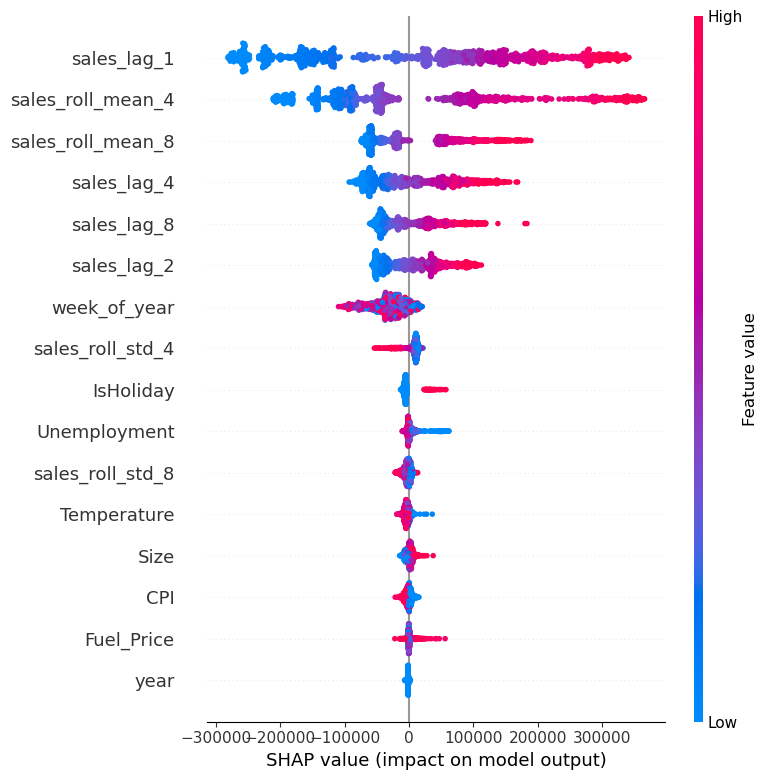

In [24]:
import shap

# Use TreeExplainer for tree-based models
explainer = shap.Explainer(gbr, X_train)
shap_values = explainer(X_val)

shap.summary_plot(shap_values, X_val, show=True)

### 15.2 SHAP Summary Interpretation
The SHAP summary plot confirms that recent demand history dominates model predictions. Short-term rolling averages and lagged sales contribute the most to both the magnitude and direction of forecasts. Calendar features such as week-of-year and holidays provide secondary signal, while macroeconomic variables and store size have comparatively small but stabilizing effects. This aligns with earlier EDA and feature importance results.

### 15.3 Local Explanation

This example illustrates single example explanations. 

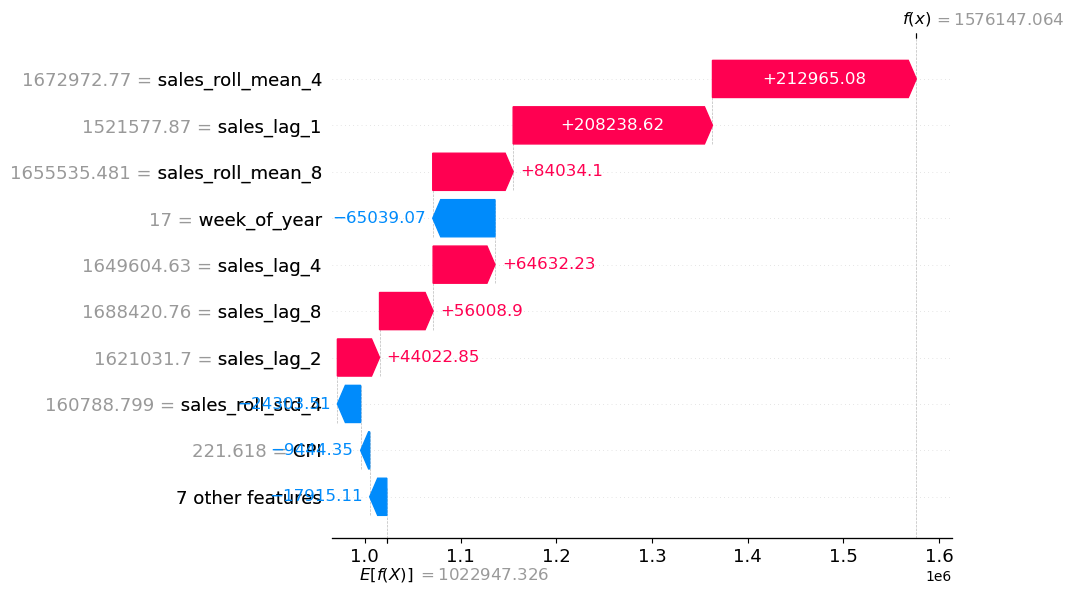

In [26]:
shap.plots.waterfall(shap_values[0])

The local explanation illustrates how recent momentum drives individuak weekly predictions, with smaller adjustments from seasonality and macro context.

## Conclusion

This project demonstrated an end-to-end retail demand forecasting pipeline using weekly Walmart sales data. After reconstructing and normalizing the dataset, exploratory analysis revealed strong seasonality, right-skewed demand, and clear structural effects driven by store characteristics. Feature engineering focused on lagged sales and rolling statistics to capture demand momentum while preventing data leakage.

Baseline models confirmed that a naive persistence approach is a strong benchmark in highly autocorrelated time series. Linear regression struggled to outperform this baseline, while tree-based models—particularly Gradient Boosting—successfully captured nonlinear interactions and residual demand patterns. SHAP analysis further validated that recent demand history is the primary driver of forecasts, with calendar and macroeconomic variables playing secondary roles.

## Next Steps

- Evaluate additional metrics such as MAE to complement RMSE in the presence of right-skewed demand.
- Experiment with target transformations (e.g., log-scaled sales) for linear and boosting models.
- Extend the model to forecast at finer granularity (e.g., store–department level).
- Incorporate promotion-aware features if reliable markdown data becomes available.
- Deploy the trained model in a lightweight forecasting application (e.g., Streamlit) to simulate real-world usage.